# 7.3 Naive Bayes Classifier based on the Binomial distribution 

In the previous notebook we built discriminant functions that carried out a Maximum Log-Likelihood Estimation (MLE). Said functions were defined as $d_k(x) = ln\ p(\mathbf{x}|C_k)$, where the vector of features $\mathbf{x}$ followed a normal distribution. In this notebook we are going to explore the case in $\mathbf{x}$ follows a **a binomial distribuion**, where the features in $\mathbf{x}$ are either $0$ or $1$ (Bernoulli trial).

Recall that we are assuming again the **naive** Bayes classifier model, so features are considered **independent**:

$$P(x_i \cap x_j) = P(x_i)p(x_j) \; \forall i,j$$

In this notebook we will learn how a naive Bayes classifier can be trained (section 7.3.1) and tested (section 7.3.2) using binomial features.

## Problem contex - Digit recognition

Digit recognition systems aim to recognize the digits appearing in different sources like emails, bank cheques, papers, images, etc. They have many real-world applications as diverse as online handwriting recognition on papers, computers, or tablets, the recognition of license plate numbers in vehicles, the processing of bank cheques' amounts, etc.

For completing the plate detector and recognition system in which we worked on in previous chapters, we are going to learn how to construct a digit recognition system using a naive Bayes classifier based on the binomial distribution. This system could be generalized to recognize any possible character appearing in the place.

<img src="./images/plateRecognition.png" width="400"/>

For this problem we need a set of digit images that will be used as training dataset for our classifier. For this application we would need to classify both digits and letters, however, to simplify this, we are going to use only digit images. In this way, the problem is reduced to 10 possible classes. You can find the provided images in `./images/train_binary/imagen{0-9}_{1-500}.png`, having 500 images for each digit.

*Note that the provided images contain handwritten digits instead of plate ones, but the training and working principles are the same.*

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

images_path = './images/'

### 7.3.1 Training a naive Bayes classifier (binomial distribution)

We will follow the same procedure as in the previous notebook, but adapted to the binomial distribution. First, we need to remember how the discriminant function of a Bayesian classifier is created:$\\[10pt]$

$$
\begin{eqnarray}
&d_k(x) &= P(C_k|\mathbf{x}) = \frac{p(\mathbf{x}|C_k)P(C_k)}{P(\mathbf{x})}
\\
\xrightarrow{P(\mathbf{x})\text{ is a constant value }\forall k} \hspace{0.2cm}&d_k(x) &= p(\mathbf{x}|C_k)P(C_k)\\[7pt]
\xrightarrow{ln \text{ doesn't alter maximum }} \hspace{0.2cm} &d_k(x) &= lnp(\mathbf{x}|C_k) + lnP(C_k)\\[7pt]
\xrightarrow{\text{If } P(C_k) = P(C_j)\; \forall \ j,k }\hspace{0.2cm} &d_k(x) &= lnp(\mathbf{x}|C_k)
\end{eqnarray}
\\[8pt]$$

In the context of our digit recognition problem, we are going to deal with images with $28x28$ pixels, where each pixel is a feature that can take the value $0$ (black pixel) or $1$ (white pixel).These images are rearranged as vectors with $28x28=784$ features:

$$\mathbf{x} = [x_1 \; x_2 \; \ldots \; x_f \; \ldots \; x_{784}]$$

This way, each image could be interpreted as a point in space with 784 dimensions. Fascinating!

Thus, considering the binomial distribution, the probability that a pixel $x_f$ belongs to a class $C_i$ is modeled as:

$$p(x_f|C_i) = (p_f^i)^{x_f} *  (1 - p_f^i)^{(1 - x_f)}$$

Being:

- $p_f^i$ the probability that $x_f = 1$ if $\mathbf{x} \in C_i$, and 
- $1-p_f^i$ the probability that $x_f = 0$ if $\mathbf{x} \in C_i$.

Again, we are assuming independence among features (we are building a **naive Bayes classifier**), so the probability $p(\mathbf{x}|C_i)$ can be expressed as the multiplication of each individual probability $p(x_f|C_i)$, that is:$\\[5pt]$

$$p(\mathbf{x}|C_i) = \Pi_{f=1}^n p(x_f|C_i) = \Pi_{f=1}^n (p_f^i)^{x_f}*(1 - p_f^i)^{(1 - x_f)}$$

Applying logarithms:$\\[7pt]$

$$ln\ p(\mathbf{x}|C_i) = \Sigma_{f=1}^n [x_f \cdot ln(p_f^i) + (1- x_f) \cdot ln\ (1-p_f^i)] =
\\
=
\Sigma_{f=1}^n x_f \cdot ln\ \frac{p_f^i}{1-p_f^i} + \Sigma_{f=1}^n ln\ (1-p_f^i)$$

Finally, for obtaining **the discriminant function** for a category $C_i$, we have to also consider the prior probability:

$$d_i(x) = ln \ p(\mathbf{x}|C_i) + ln \ P(C_i) = \underbrace{ln \ P(C_i) + \Sigma_{f=1}^n ln\ (1-p_f^i)}_{w_{n+1}^i} + \Sigma_{f=1}^n x_f \cdot \underbrace{ln\ \frac{p_f^i}{1-p_f^i}}_{w_f^i}$$

As we can see, **the function is lineal** (and ideal!).

**Implementation detail:** it is recommended to avoid values of 0 or 1 for $p_f^i$ since numerical problems may appear. Instead, take values close to 0 or 1. We will see this in a later assignment. 

### **<span style="color:green"><b><i>ASSIGNMENT 1a: Setting up the data</i></b></span>**

The first step for training the classifier is preparing the data (this is often called the preprocessing step). In the context of our problem, this is done by vectorizing each image. 

**Our task** is to construct a matrix containing all the images' data, which can be found at: `./images/train_binary/imagen{0-9}_{1-500}.png`. This matrix will have 3 dimensions: $(n\_pixels, n\_images, n\_classes)$. Thus, each column of the matrix (second dimension) would contain a vectorized version of its corresponding image, having `n_images` in total. The third dimension indexes the different classes, having this problem a total of 10 (digits from 0 to 9).

The image below illustrates the vectorization process of an image:

<img src="./images/vectorize.png" width="700"/>

In this way, **you have to** read all the images (there are 500 for each digit) and obtain the mentioned matrix storing all the data. Notice that the provided images are grayscale, so you will have to **binarize** them first using OpenCV, thus they can be used to build a binomial distribution.

In [5]:
## Training

# Initialize matrix
r,c = 28,28
dataset = np.zeros((r*c,500,10))
# For each class
for number in range(10):
    # For each image in the class
    for i in range(1,501):
        # Read the image
        path = images_path + "train_binary/imagen" + str(number) + "_" + str(i) + ".png"
        image = cv2.imread(path,0)
        # Binarize it
        _,binarized = cv2.threshold(image,100,1,cv2.THRESH_BINARY)
        vector_binarized = binarized.reshape((-1,1))
        # Reshape it
        dataset[:,i-1,number] = vector_binarized[:,0]

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


### **<span style="color:green"><b><i>ASSIGNMENT 1b: Computing probabilities</i></b></span>**

After the preprocessing step, we will compute the different $p_f^i$ modeling the probability that $x_f = 1$ if $\mathbf{x} \in C_i$. These probabilities will allow us to compute the weights in a later step. Recall how the decision functions are built:

$$d_i(x) = ln \ p(\mathbf{x}/C_i) + ln \ P(C_i) = \underbrace{ln \ P(C_i) + \Sigma_{f=1}^n ln\ (1-p_f^i)}_{w_{n+1}^i} + \Sigma_{f=1}^n x_f \cdot \underbrace{ln\ \frac{p_f^i}{1-p_f^i}}_{w_f^i}$$

Luckily, considering a binomial distribution, computing these probabilities is straightforward. We just have to count the number of times that each pixel (feature $x_f$) takes the value `1` in each class, and divide it by the number of images used ($N$):

$$p_{f}^i = \frac{1}{N}\Sigma_{k=1}^{N}x_{f,k}^{i}$$$\\[3pt]$

Regarding our problem:
- $N=500$ as we have $500$ images for each class. 
- The range of the index of features $f$ is $[0-783]$ as images have $28x28=784$ pixels.

The following image illustrates the process of computing these probabilities:

<img src="./images/probabilities.png" width="700"/>$\\[2pt]$

**What to do?** 
1. Construct a 2D matrix **containing all the probabilities** ($matrix[f,i] = p_f^i$). 
2. Then, we are going to visualize the **prototype images**, also called **heatmaps**. There is a heatmap for each digit. In these images, the value of a pixel represent its probability of being `1` (black on a white paper sheet). For doing that, we have to **unvectorize the probabilities** in the matrix (2D $\rightarrow$ 3D) and **plot the heatmaps**. This is also a good way to check if we are doing well.

You should obtain something similar to this:

<img src="./images/heatmaps.png" width="700"/>

*Tip: try to use [`np.sum()`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) for computing the probaiblities in order to avoid loops, which are usually slower (check the `axis` argument).* ***You can compute probabilities in just one code line!***

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


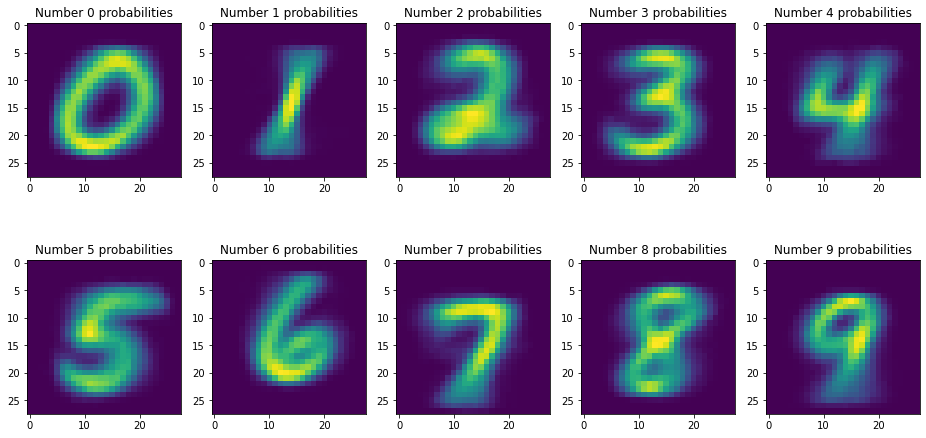

In [17]:
# Compute probabilities
probabilities = np.sum(dataset, axis=1)/np.shape(dataset)[1]

# Reshape to obtain heatmaps
heatmaps = probabilities.reshape(r,c,10)

# Plot heatmaps
for i in range(2):
    for j in range(5):
        plt.subplot(2,5, i*5+(j+1))
        plt.title("Number " + str(i*5+j) + " probabilities")
        plt.imshow(heatmaps[:,:,i*5+j])

### **<span style="color:green"><b><i>ASSIGNMENT 1c: Computing weights</i></b></span>**

Once we have retrieved the probabilities $p_f^i$, we are ready to obtain **the weights** that define the discriminant function for each class. This is the last training step! Recall that these weights are defined as:

$$
\begin{eqnarray}
w_f^i &=& ln\ \frac{p_f^i}{1-p_f^i}\\[5pt]
w_{n+1}^i &=& ln\ P(C_i) + \Sigma_{f=1}^n ln(1- p_f^i)
\end{eqnarray}
$$

Being:
- $i$: one of the 10 possible classes, and
- $f$: a feature in the range $[0,\dots,783]$.

**What to do?** Construct a 2D matrix containing the weights of the classifier. Consider the following:

- Since we can't neither divide by 0 nor compute the logarithm of 0, during the weights computation, **0 and 1 probabilities should be replaced by close numbers** (e.g. 0.0001 and 0.9999). This can be done using [`np.where()`](https://numpy.org/doc/1.18/reference/generated/numpy.where.html).  
- As we don't have any prior information about the occurences of each class, the prior probability $P(C_i)$ should be $1/n\_classes$ for each class $i$.

*Hint: For applying the natural logarithm to all the elements of a matrix, you can use [`np.log()`](https://numpy.org/doc/1.18/reference/generated/numpy.log.html?highlight=log#numpy.log).*

In [18]:
## Weight calculation

# Replace 0 and 1 values
probabilities = np.where(probabilities==0, 0.001, probabilities)
probabilities = np.where(probabilities==1, 0.999, probabilities)

# Initialize matrix
weights = np.zeros((r*c+1,10))

# Compute weights
weights[:-1,:] = np.log(probabilities/(1-probabilities))
weights[-1,:] = np.log(0.1) + np.sum(np.log(1-probabilities),axis=0)

### 7.3.2 Testing the classifier

In the last step we retrieved the weights $w_{n+1}^i$ and $w_f^i$, so now we have all the building blocks needed to design the discriminant function of each class $d_i(x) \; (i=0,1,\ldots,9)$. These decision functions permit us to evaluate a new vector $\mathbf{x}$ corresponding to a new vectorized image and retrieve its most probable category:

$$d_i(\mathbf{x}) = w_{n+1}^i + \Sigma_{f=0}^{783}w_f^i \cdot x_f \quad i = 0,\ldots, 9$$

In this way, each discriminant function, after evaluating the vector of features, will return a number. As we are estimating the **maximum log-likelihood**, the assigned class will be the one corresponding to the discriminant function returning the highest value.

### **<span style="color:green"><b><i>ASSIGNMENT 2</i></b></span>**

For this exercise, it is provided a `numPy` matrix called `digitos.npy`, which is located at `./test_binary/`. It is a 1D matrix with 50 elements containing the ground truth information of 50 images, `./test_binary/timage{1-50}`. That is, the matrix codifies the digit, from 0 to 9, that each image contains. 

**Your task** is to classify those 50 images and check if the output of your classifier matches with the actual class, as provided in `digitos.npy`. In this way, we can estimate how good is our classifier.

*Note: If you trained your classifier with the provided images, you should expect 41/50 hits, or a 82% of accuracy.*

In [23]:
## Testing

# Load provided matrix
results = np.load(images_path + "test_binary/digitos.npy")
hits = 0

# Classify each testing image
for i in range(1,51):
    f_pesos = np.zeros((10))
    # Read the image
    path = images_path + "test_binary/timage" + str(i) + ".png"
    image = cv2.imread(path,0)
    # Binarize it
    _,binarized = cv2.threshold(image,100,1,cv2.THRESH_BINARY)
    # Vectorize it
    vector_binarized = binarized.reshape((-1,1))
    vector_binarized = np.append(vector_binarized,[1])
    # Evaluate the discriminant functions
    for j in range(10):
        f_pesos[j] = np.sum(weights[:,j] * vector_binarized)
    # Get the maximum
    res = np.where(f_pesos == np.amax(f_pesos))
    if res == results[i-1]:
        hits = hits + 1
        
# Print the accuracy
print("Accuracy=" + str(hits) + "/50 (" + str(100.0*hits/50.0) + "%)" )

Accuracy=41/50 (82.0%)


### **<span style="color:green"><b><i>EXTRA: ASSIGNMENT 3</i></b></span>**

Do you dare to try your brand new classifier with your own images? Brilliant! For that:

1. Write a digit in a paper and make a photo with your phone. The following image shows an example (you can try with different numbers, of course!).$\\[5pt]$
<img src="./images/testcamera.jpeg" width="300"/>$\\[5pt]$
2. Then, segment the region of interest (crop the digit, see the left image in the figure below). 
3. Resize the image to $28\times28$ pixels (this is the input image size of our classifier). You can use [`cv2.resize()`](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d)for that. 
4. Finally, binarize (see the right image in the figure below) and vectorize the image. 
<img src="./images/extra_example.png" width="700"/>
5. Follow the steps done in *assignment 2* to classify the image and show the results!

Image classified as [5]


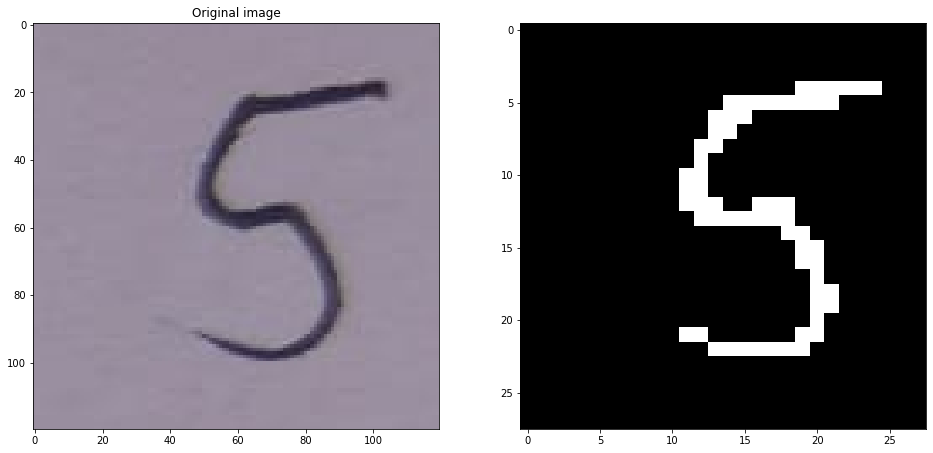

In [ ]:
## Testing with our own image

# Read image and convert it to grayscale
color_image = cv2.imread(images_path + 'testcamera.jpeg', -1)
color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

# Crop ROI
color_image = color_image[380:500,1390:1510,:]
image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

# Binarize it
image = cv2.resize(image,(r,c))
_,binarized = cv2.threshold(image,130,1,cv2.THRESH_BINARY_INV)

# Reshape the image
vector_binarized = binarized.reshape((-1,1))
vector_binarized = np.append(vector_binarized,[1])

# Evaluate the discriminant functions
for j in range(10):
    f_pesos[j] = np.sum(weights[:,j] * vector_binarized)
    
# Get the maximum
res = np.where(f_pesos == np.amax(f_pesos))

# Plot the results
plt.subplot(121)
plt.imshow(color_image)
plt.title("Original image")
plt.subplot(122)
plt.imshow(binarized,cmap="gray")
print("Image classified as " + str(res[0]))

## Conclusion

Excellent! You have learned how to:

- design and train a naïve Bayes classifier based on the binomial distribution for binary images,
- test and obtain the accuracy of the classifier,
- recognize digits in the context of plate characters (notice that the handwritten digits dataset used in the assignments could be replaced by any other containing plate characters!).